In [2]:
from pennylane import numpy as np
import pennylane as qml
import pickle
from scipy.linalg import eigh
from scipy.linalg import det

In [3]:
def angstrom_to_bohr(dist):
    return dist*1.88973

In [4]:

# Multiplication rule for two Pauli matrices
def multiply(s1, s2):
    if s1=='I':
        return 0, s2
    if s2=='I':
        return 0, s1
    if s1==s2:
        return 0,'I'
    else:
        
        if s1=='X':
            if s2=='Y':
                return 1, 'Z' #XY = iZ
            else:
                return 3, 'Y' #XZ = -iY
        elif s1=='Y':
            if s2=='X':
                return 3, 'Z' #YX = -iZ
            else:
                return 1, 'X' #YZ = iX
        else:
            if s2=='X':
                return 1, 'Y' #ZX = iY
            else:
                return 3, 'X' #ZY = -iX
                

# Multiply two Pauli words and keep track of the phase
def P_multiply(P1,P2):
    #if len(P1)!=len(P2):
    #    raise Exception("Pauli words must have the same length")
        
    Phase = 0
    P = ''
    for i in range(len(P1)):
        phase, s = multiply(P1[i], P2[i])
        Phase += phase
        P += s
    return Phase%4, P


In [5]:
# Return the Pauli words of H in string form
def extract_basis_str(H, wire_map):
    
    N = len(H.coeffs)
    basis_str = set()
    for i in range(N):
        basis_str.add( qml.pauli.pauli_word_to_string(H.ops[i], wire_map = wire_map) )
    return basis_str



# Generate the cummulative space CSK
def cummulative_space(H,K, wire_map):
    
    CSK = set()
    if K==0:
        Id = 'I'
        for i in range(qubits-1):
            Id += 'I'
        return {Id}
    
    elif K==1:
        return extract_basis_str(H, wire_map)
    
    else:
        CS1 = extract_basis_str(H, wire_map)
        
        Id = 'I'
        for i in range(qubits-1):
            Id += 'I'
            
        basis = [{''.join(['I' for _ in range(qubits_tap)])},CS1]
        for k in range(K-1):
            CSK.update(basis[-2])
            basis.append(  increment_cummulative_space( basis[-1].difference(a)  ,CS1)   )
        CSK.update(*basis[-2:])
    return CSK


# Help generate the cummulative space
def increment_cummulative_space(basis, CS1):
    N = len(basis)
    n = len(CS1)
    SK = set()
        
    for s1 in basis:
        for s2 in CS1:
            _, P = P_multiply(s1, s2)
            SK.add(P)
    return SK

In [6]:

def expectation_value(P1,P2,P3=None):

    
    if P3==None:
        phase, P = P_multiply(P1,P2)
    else:
        phase_, P_ = P_multiply(P1,P3)
        phase, P = P_multiply(P_,P2)
        phase += phase_
        
    dev = qml.device("default.qubit", wires=qubits_tap)
    @qml.qnode(dev)
    def expect(P):
        # initial state to add
        with open('gs.pkl','rb') as f:
            x = pickle.load(f)
        qml.QubitStateVector(x, range(qubits_tap))
        
        return qml.expval(qml.pauli.string_to_pauli_word(P))
    return np.exp(1j*np.pi*phase/2)*expect(P)



# Construct the overlap matrix S
def S_mat(basis):
    N = len(basis)
    S_mat = np.ones((N,N), dtype=complex)
    for i in range(N):
        for j in range(i):
            S_mat[i,j] = expectation_value(basis[i],basis[j])
            S_mat[j,i] = S_mat[i,j].conjugate()
    return S_mat


# Construct the matrix D
def D_mat(basis, H):
    N = len(basis)
    D_mat = np.zeros((N,N), dtype=complex)

    for i in range(N):
        for j in range(i):
            D_mat[i,j] = sum([ H.coeffs[k]*\
                                expectation_value(basis[i],basis[j], qml.pauli.pauli_word_to_string(H.ops[k], wire_map))\
                                for k in range(len(H.coeffs))])
            D_mat[j,i] = D_mat[i,j].conjugate()
        D_mat[i,i] = sum([ H.coeffs[k]*\
                                expectation_value(basis[i],basis[i], qml.pauli.pauli_word_to_string(H.ops[k], wire_map))\
                                for k in range(len(H.coeffs))]).real
    
    return D_mat

### Molecule

In [25]:
symbols = ["H","Be","H"]
dist = 1.291
geometry = angstrom_to_bohr( np.array([[0, 0, -dist],[0.,0,0],[0,0,dist]]) )
mol = qml.qchem.Molecule(symbols, geometry)

In [26]:
active_electrons = 4
active_orbitals = 6

H, qubits = qml.qchem.molecular_hamiltonian(mol.symbols,
                                            mol.coordinates,
                                            active_electrons=active_electrons,
                                            active_orbitals=active_orbitals,
                                                      grouping_method = 'qwc',
                                                      args=[mol.coordinates])

### Tapering

In [27]:
generators = qml.symmetry_generators(H)
paulixops = qml.paulix_ops(generators, qubits)
paulix_sector = qml.qchem.optimal_sector(H, generators, active_electrons)

H_tapered = qml.taper(H, generators, paulixops, paulix_sector)

In [28]:
qubits_tap = qubits-len(paulixops)
wire_tapered = [ paulixops[i].wires[0] for i in range(len(paulixops))]
wire_tap = [ x for x in range(qubits) if not x in wire_tapered ]
wire_map = {wire:i for i,wire in enumerate(wire_tap)}

### Generalized eigenvalue problem

In [47]:
basis = ['IIIIIII','XIIIIII','IXIIIII','IIXIIII','IIIXIII','IIIIXII','IIIIIXI','IIIIIIX']

S = S_mat(basis)
print(det(S))

(0.9751257915930351+0j)


In [48]:
D = D_mat(basis, H_tapered)

In [52]:
vals, vect = eigh(D,S, eigvals_only=False)
print(vals)

[-15.59408252 -14.95054204 -14.55343213 -14.42904849 -12.58930074
 -10.71944452 -10.69859598 -10.2702529 ]


-15.59408238 <- ['IIIIII']
-15.59408242 <- ['IIIIIII','IIIXIII','IIYIYII']
-15.59408252 <- ['IIIIIII','XIIIIII','IXIIIII','IIXIIII','IIIXIII','IIIIIIX']

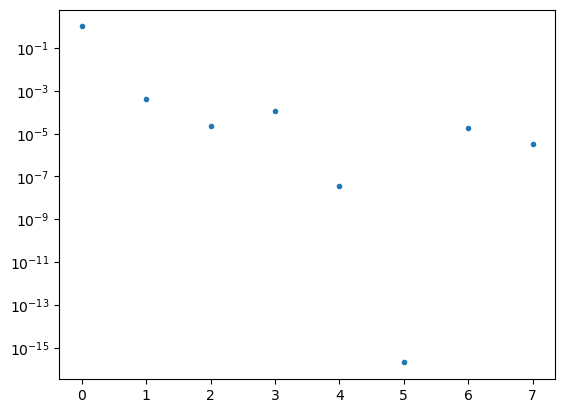

In [55]:
from matplotlib import pyplot as plt


plt.plot(abs(vect[0])**2,'.')
plt.yscale('log')